In [1]:
import random

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xarray as xr
from dask.distributed import Client, LocalCluster
from deap import algorithms, base, creator, tools
from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    EnvironmentParameter,
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_environment import ClientParameter
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import logger, set_debug, set_error
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

random.seed(64)

In [2]:
xr.set_options(
    keep_attrs=True,
    display_expand_attrs=False,
    display_expand_data=False,
    display_expand_coords=False,
    display_expand_data_vars=False,
)

WET_TO_CARBON = 1 / 11.9

logger.setLevel("ERROR")

## Forcing


Forcing data from seapodym model


In [3]:
hot_data = xr.open_dataset("../1_data_processing/1_1_Forcing/bats_cmems.zarr", engine="zarr")
hot_data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
hot_data.load()

<xarray.Dataset> Size: 839kB
Dimensions:              (time: 9116, depth: 3, latitude: 1, longitude: 1)
Coordinates: (4)
Data variables: (13)
Attributes: (10)

In [4]:
hot_data.zooc[:, 0, 0].pint.quantify().pint.to("kg/m^2").mean()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/namedarray/core.py:215: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return NamedArray(dims, np.asarray(data), attrs)


<xarray.DataArray 'zooc' ()> Size: 4B
0.0003476
Coordinates: (2)
Attributes: (2)

Observation data from Hot station


In [5]:
hot_obs = xr.open_dataset("../1_data_processing/1_1_Forcing/bats_obs.zarr", engine="zarr")
hot_obs.load()

<xarray.Dataset> Size: 15MB
Dimensions:                        (time: 4242, depth: 8, latitude: 1,
                                    longitude: 1, sieve_size: 5)
Coordinates: (5)
Data variables: (39)

Generate the observed zooplankton data to be used further in the cost function


In [6]:
epi_layer_depth = hot_data.pelagic_layer_depth.cf.isel(depth=0, Y=0, X=0)

In [7]:
zoo_obs = (
    (hot_obs["dry_weight_migrant"] + hot_obs["dry_weight_resident"]).sum("sieve_size").mean("depth").cf.isel(Y=0, X=0)
)
zoo_obs = zoo_obs.where(zoo_obs > 0, drop=True) * WET_TO_CARBON
zoo_obs = zoo_obs * epi_layer_depth
zoo_obs.attrs["units"] = zoo_obs.attrs["units"].replace("m^3", "m^2")
zoo_obs = zoo_obs.pint.quantify().pint.to("kg/m^2")
zoo_obs.mean()


zoo_obs_migrant = hot_obs["dry_weight_migrant"].sum("sieve_size").mean("depth")
obs_zoo_resident = hot_obs["dry_weight_resident"].sum("sieve_size").mean("depth")
zoo_obs = zoo_obs_migrant + obs_zoo_resident
zoo_obs = zoo_obs.where(zoo_obs > 0, drop=True).rename("observation")[:, 0, 0]
zoo_obs = zoo_obs.pint.quantify().pint.to("mg / meter ** 2").pint.dequantify()
zoo_obs = zoo_obs.to_series().resample("1ME").mean().dropna()
zoo_obs

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/namedarray/core.py:215: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return NamedArray(dims, np.asarray(data), attrs)


<xarray.DataArray ()> Size: 8B
5.499e-06
Coordinates: (3)
Attributes: (36)

## Function to automatically generate model


In [8]:
def gen_fgroup(
    tr_max: float = 10.38,
    tr_rate: float = -0.11,
    inv_lambda_max: float = 150,
    inv_lambda_rate: float = 0.15,
    day_layer: float = 1,
    night_layer: float = 1,
    energy_transfert: float = 0.1668,
) -> FunctionalGroups:
    """Generate a FunctionalGroups object with the given parameters."""
    return FunctionalGroups(
        functional_groups=[
            FunctionalGroupUnit(
                name=f"D{day_layer}N{night_layer}",
                migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
                functional_type=FunctionalGroupUnitRelationParameters(
                    inv_lambda_max=inv_lambda_max,
                    inv_lambda_rate=inv_lambda_rate,
                    temperature_recruitment_rate=tr_rate,
                    cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                    temperature_recruitment_max=tr_max,
                ),
                energy_transfert=energy_transfert,
            )
        ]
    )


def gen_model(forcing_parameters, functional_groups_parameters, **kwargs) -> NoTransportModel:
    """
    Generate a NoTransportModel with the given parameters.

    kwargs:
        - environment_parameters: EnvironmentParameter = EnvironmentParameter,
        - kernel_parameters: KernelParameters = KernelParameters
    """
    return NoTransportModel(
        configuration=NoTransportConfiguration(
            parameters=NoTransportParameters(
                forcing_parameters=forcing_parameters,
                functional_groups_parameters=functional_groups_parameters,
                **kwargs,
            )
        )
    )

## Setup


The forcing data


In [9]:
hot_data_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=hot_data["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=hot_data["npp"], resolution=0.08333),
)

The initial conditions


In [10]:
fgroups = gen_fgroup()
setup_model = gen_model(
    hot_data_parameter,
    fgroups,
    kernel_parameters=KernelParameters(compute_initial_conditions=True, compute_preproduction=True),
)
setup_model.run()
initial_conditions = setup_model.export_initial_conditions()

Update the forcing data with initial conditions


In [11]:
hot_data_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=hot_data["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=hot_data["npp"], resolution=0.08333),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["initial_condition_biomass"], resolution=0.08333),
    initial_condition_production=ForcingUnit(
        forcing=initial_conditions["initial_condition_production"], resolution=0.08333
    ),
)

## Cost function


In [12]:
from typing import Literal


def cost_function(args: tuple[float, float, float, float, float], method: Literal["MAE", "MSE"] = "MSE"):
    """Use the Mean Absolute Error (MAE) method or the Mean Squared Error (MSE) method to calculate the cost."""
    (
        energy_transfert,
        tr_max,
        tr_rate,
        inv_lambda_max,
        inv_lambda_rate,
    ) = args
    if tr_rate > 0:
        tr_rate = -tr_rate
    fgroups = gen_fgroup(
        energy_transfert=energy_transfert,
        tr_max=tr_max,
        tr_rate=tr_rate,
        inv_lambda_max=inv_lambda_max,
        inv_lambda_rate=inv_lambda_rate,
    )

    setup_model = gen_model(hot_data_parameter, fgroups)
    setup_model.run()

    biomass_pred = setup_model.export_biomass().pint.quantify().pint.to("mg / meter ** 2").pint.dequantify()
    biomass_pred = biomass_pred[0, :, 0, 0].rename("prediction")
    biomass_pred = biomass_pred.to_series()
    biomass_pred = biomass_pred.resample("1ME").mean().dropna()
    if method == "MSE":
        cost = float(((zoo_obs - biomass_pred) ** 2).mean())
    else:
        cost = float(np.abs((zoo_obs - biomass_pred)).mean())

    return (cost,)

## DEAP - Genetic algorithm


Create the population of the genetic algorithm.


In [13]:
def random_exclusive(a, b):
    if a >= b:
        raise ValueError("La borne inférieure doit être inférieure à la borne supérieure.")

    while True:
        value = random.uniform(a, b)
        if value != a and value != b:
            return value


parameters_boundaries = {
    "energy_transfert": (0, 0.5),
    "tr_max": (0, 50),
    "tr_rate": (0, 1),
    "inv_lambda_max": (1, 1000),
    "inv_lambda_rate": (0, 1),
}
lower_boundary = [values[0] for values in parameters_boundaries.values()]
upper_boundary = [values[1] for values in parameters_boundaries.values()]

ETA = 0.1
INDPB = 0.1  # 0.05
CXPB = 0.5
MUTPB = 0.2  # 0.1
NGEN = 15
number_of_individuals = 100

In [14]:
toolbox = base.Toolbox()

creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

for parameter, boundaries in parameters_boundaries.items():
    lb, ub = boundaries
    toolbox.register(parameter, random_exclusive, lb, ub)

toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.energy_transfert,
        toolbox.tr_max,
        toolbox.tr_rate,
        toolbox.inv_lambda_max,
        toolbox.inv_lambda_rate,
    ),
    n=1,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", cost_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, indpb=INDPB, low=lower_boundary, up=upper_boundary)
toolbox.register("select", tools.selTournament, tournsize=3)

The main function to run the genetic algorithm.


In [16]:
client = Client()
client

In [17]:
def main_manual(population, toolbox, cxpb, mutpb, ngen, verbose=__debug__):
    halloffame = tools.HallOfFame(100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    invalid_ind_as_list = [list(ind) for ind in invalid_ind]  # For compatibility with DASK
    futures_results = client.map(toolbox.evaluate, invalid_ind_as_list)
    fitnesses = client.gather(futures_results)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        invalid_ind_as_list = [list(ind) for ind in invalid_ind]  # For compatibility with DASK
        futures_results = client.map(toolbox.evaluate, invalid_ind_as_list)
        fitnesses = client.gather(futures_results)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook, halloffame


pop, logbook, hof = main_manual(
    population=toolbox.population(n=number_of_individuals),
    toolbox=toolbox,
    cxpb=CXPB,
    mutpb=MUTPB,
    ngen=NGEN,
)

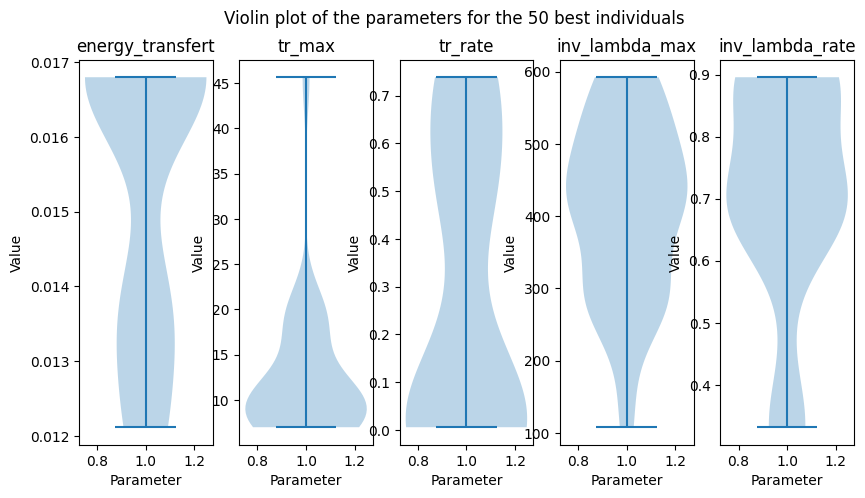

In [25]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
for idx, ax, name in zip(range(5), [ax1, ax2, ax3, ax4, ax5], parameters_boundaries.keys()):
    ax.set_title(name)
    ax.set_ylabel("Value")
    ax.set_xlabel("Parameter")
    ax.violinplot(np.asarray(hof.items)[:, idx])

# print the main title
plt.suptitle(f"Violin plot of the parameters for the {len(hof.items)} best individuals")

plt.show()

Parameters initial values:

-   energy_transfert: float = 0.1668
-   tr_max: float = 10.38
-   tr_rate: float = -0.11
-   inv_lambda_max: float = 150
-   inv_lambda_rate: float = 0.15


In [32]:
print("Best individual is: ")
for name, value in zip(parameters_boundaries.keys(), hof[0]):
    print(f"{name} : {value}")

Best individual is: 
energy_transfert : 0.016796145506284887
tr_max : 6.991772867914092
tr_rate : 0.00583199040589677
inv_lambda_max : 436.56490612278674
inv_lambda_rate : 0.6813143194333244


In [27]:
# run the model for this parameters
best_run = gen_model(
    hot_data_parameter,
    gen_fgroup(
        energy_transfert=hof[0][0],
        tr_max=hof[0][1],
        tr_rate=hof[0][2],
        inv_lambda_max=hof[0][3],
        inv_lambda_rate=hof[0][4],
    ),
)
best_run.run()

In [ ]:
pred = best_run.export_biomass()[0, :, 0, 0].to_dataframe()["biomass"]
obs = zoo_obs.rename("biomass_obs").to_dataframe()["biomass_obs"]

In [29]:
from plotly import graph_objects as go

In [33]:
go.Figure(
    [
        go.Scatter(x=pred.index, y=pred, name="Prediction"),
        go.Scatter(x=obs.index, y=obs, name="Observations"),
    ]
)